# Figure 3: Long-Term Energy Error
This notebook recreates Figure 3 in Rein & Tamayo 2017. We ran 24 simulations of the Solar System for three hundred million years and check for energy conservation. The simulations were archived with the SimulationArchive. We first download the SimulationArchives from zenodo. This may take a while depending on your internet connection.

In [1]:
import urllib.request, os

Ndownloads = 24
zenodourl  = "https://zenodo.org/record/546258/files/"
localpath  = "datafiles/"

if not os.path.exists(localpath):
    os.makedirs(localpath)
    for i in range(Ndownloads):
        filename = "restart_%04d.bin"%i
        urllib.request.urlretrieve (zenodourl+filename, localpath+filename);

Next, we compile a shared library to handle the general relativistic corrections. We do this in C for speed. The code is compiled from within python for convenience. Depending on your operating system, you might have to change the compiler options.

In [2]:
import subprocess
rebounddir = "/Users/rein/git/rebound/"
force_c = b"""
#include "rebound.h"

void gr_force(struct reb_simulation* const r){
    const struct reb_particle source = r->particles[0];
    const double C2 = 1.0130251e+08;
    const double prefac1 = 6.*(r->G*source.m)*(r->G*source.m)/C2;

    for (int i=1;i<r->N;i++){
        const struct reb_particle p = r->particles[i];
        const double dx = p.x - source.x;
        const double dy = p.y - source.y;
        const double dz = p.z - source.z;
        const double r2 = dx*dx + dy*dy + dz*dz;
        const double prefac = prefac1/(r2*r2);
        r->particles[i].ax -= prefac*dx;
        r->particles[i].ay -= prefac*dy;
        r->particles[i].az -= prefac*dz;
        r->particles[0].ax += p.m/source.m*prefac*dx;
        r->particles[0].ay += p.m/source.m*prefac*dy;
        r->particles[0].az += p.m/source.m*prefac*dz;
    }
}
"""
p = subprocess.Popen(["cc", "-I"+rebounddir+"src/", "-xc", "-shared", "-std=c99", "-fpic", "-o","force.so","-"], stdout=subprocess.PIPE,stderr=subprocess.PIPE, stdin=subprocess.PIPE)
so, se = p.communicate(force_c)
if len(se)>0: # print out any errors
    print(se.decode())

Now, we can load REBOUND and create the functions needed to setup and analyze simulation with general relativistic corrections.

In [4]:
import rebound,warnings,glob
print(rebound.__build__,rebound.__githash__)
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from ctypes import cdll, byref
cgr = cdll.LoadLibrary("force.so")
def setup(sim):
    sim.additional_forces=cgr.gr_force
def gr_potential(sim):
    source = sim.particles[0]
    mu = sim.G*source.m
    prefac = 3.*mu*mu/1.0130251e+08
    grpot = 0.
    for i in range(1,sim.N):
        pi = sim.particles[i] - source
        r2 = pi.x*pi.x + pi.y*pi.y + pi.z*pi.z
        grpot -= prefac*sim.particles[i].m/r2
    return grpot

Apr 15 2017 21:13:57 c7e77b838d033099915dd47d9f2d7a6479daf788


We now load all SimulationArchives....

In [5]:
sasJANUS = []
for f in glob.glob("datafiles/*.bin"):
    sasJANUS.append(rebound.SimulationArchive(f,setup=setup))

/Users/rein/git/rebound/rebound/simulationarchive.py:63: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed.
  warnings.warn(BINARY_WARNINGS[1][0], RuntimeWarning)


... and calculate the energy error, taking into account the GR potential. 

In [6]:
tmin = 2e5
tmax = 0.99*min([sa.tmax for sa in sasJANUS])
times = np.logspace(np.log10(tmin), np.log10(tmax),1000,endpoint=False) #sa.tmax, 300)
dataJ = np.zeros((len(sasJANUS),len(times)))

for k,sa in enumerate(sasJANUS):
    for i, sim in enumerate(sa.getSimulations(times)):
        dataJ[k][i] = sim.calculate_energy()+gr_potential(sim)
    for i in range(1,len(times)):
        dataJ[k][i] = np.abs((dataJ[k][i]-dataJ[k][0])/dataJ[k][0])

We can then finally create the figure.

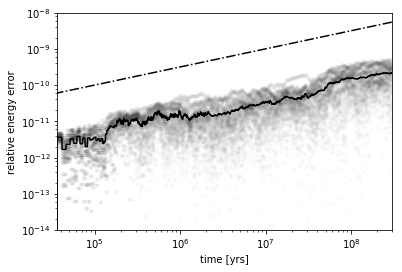

In [7]:
f, (ax1) = plt.subplots(1,1, sharey=True,figsize=(6, 4))

ax1.set_ylim([1e-14,1e-8])
ax1.set_xlim([times[15]/2/np.pi, tmax/2/np.pi])
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_xlabel("time [yrs]")
ax1.set_ylabel("relative energy error")
for k in range(len(sasJANUS)):
    ax1.scatter(times[5:]/2/np.pi,dataJ[k,5:],marker=".",color="#555555",alpha=0.015)

ax1.plot(times[5:]/2/np.pi,np.mean(dataJ[:,5:],axis=0),color="black")    
ax1.plot(times[5:]/2/np.pi,1e-10*np.sqrt(times[5:]/2/np.pi/1e5),"-.",color="black")    

plt.savefig("janus_longterm.pdf", format='pdf', bbox_inches='tight', pad_inches=0)